# Introduction to Monte Carlo (MC) uncertainty propagation

MC error propagation can be very useful when a derivation for a given uncertainty is too complicated to calculate, when one is too lazy to derive many functions, or simply when the operator does not feel comfortable enough anymore to derive an uncertainty propagation without mathematical errors. MC error propagation - compared to regular error propagation - furthermroe does not intrinsically assume that an uncertainty of a given measurement around its mean value is normally distributed, actually any distribution can be assumed.  
In this introduction however we will assume that everything follows a Gaussian distribution. Let us however have a look on how to generate random numbers and how to test the random number generator in python

## Random numbers
MC methods depend heavily on radnom number generators. However, a computer cannot generate true random number and uses pseudo random number generators. In python, we can use the random package that is distributed with numpy. Let us have a look on how to use this package and see if these numbers look - at least optically - randomly distributed.

### Random numbers between 0 and 1

In [1]:
import numpy as np   # of course we should import the NumPy package
import matplotlib.pyplot as plt   # to optically check if things are randomly distributed

# generate a random number between 0 and 1 and print it
print(np.random.rand())

0.6687112458501131


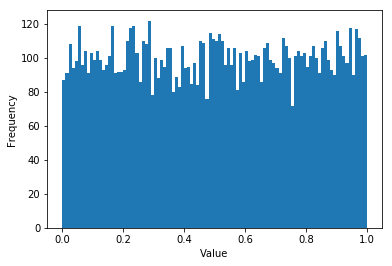

In [2]:
# create 100000 random numbers and plot them in a histogram of 100 bins. we should see pretty much
# equal bin size of 100 bins with 100 entries each
rn = np.random.rand(10000)

# make the histogram
plt.figure(1)
rn_hist = plt.hist(rn, bins=100)   # we are also going to save the histogram for further use...
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

You can print and run this histogram over and over again and will see that numbers are pretty equally distributed. Give it a try and plug in more random numbers. How high do you need to go, i.e., how many random numbers do you need to generate until the histogram looks pretty much flat?

Let us now have a look on what the mean and the standard deviation of this random number package looks like. Note: here we are checking how many entries the bins have on average (and not what the mean of the distribution is). We can use the associated numpy functions:

In [3]:
rn_avg = np.mean(rn_hist[0])
rn_std = np.std(rn_hist[0])
print("Average: %.3f, Standard deviation: %.3f" % (rn_avg, rn_std))

Average: 100.000, Standard deviation: 10.282


This looks pretty good, the average is where we expect it and the standard deviation makes sense too. We can also look at the mean of the distribution and its standard deviation:

In [4]:
print('Average: %.3f, Standard deviation: %.3f' %(np.mean(rn), np.std(rn)))

Average: 0.502, Standard deviation: 0.290


This looks as expected as well. So the random number generator seems to work. 

### Gaussian distributed random numbers
For a given measurement we usually don't assume that the uncerainty is distributed with equal chances. We expect a Gaussian distribution. NumPy has a function for this as well. Let us create 10000 samples that are Gaussian distributed around 0:

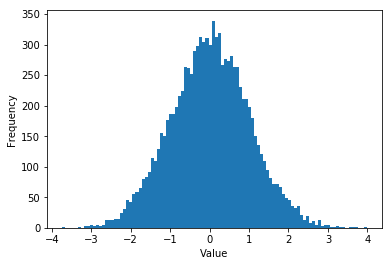

In [5]:
gn = np.random.randn(10000)   # Note: randn instead of rand - stands for 'random normal'

# plot a histogram
plt.figure(2)
gn_hist = plt.hist(gn, bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

This looks pretty Gaussian at first glance, so it seems to work. Let's have a look at the mean and standard deviation of all the values this time:

In [6]:
gn_avg = np.mean(gn)
gn_std = np.std(gn)
print('Average of distribution: %.3f, Standard deviation: %.3f' % (gn_avg, gn_std))

Average of distribution: 0.015, Standard deviation: 0.998


As expected, the average of the distribution is about zero. The standard deviation - big surprise - is about 1. This is expected, since this distribution is exactly used to define the standard deviation.

So far so good, our random number generators seem to work. Now let's define an experimental setup that we want to analyze. Let's choose a simple system that we can easily solve numerically as well.

## Experiment setup and analytical evaluation
Let us assume a radioactively decaying species. We measure the number of atoms at the beginning $N_0$ at the number of atoms after a given time t as $N(t)$. The radioactive decay equation with decay constant $\lambda$ can then be written as:

$$N(t) = N_0 \exp{(-\lambda t)}$$

Assuming we want to measure the decay constant $\lambda$, we can solve above equation for $\lambda$:

$$\lambda = \frac{1}{t} \ln \left(\frac{N(t)}{N_0}\right)$$
Of course, every measurement has an uncertainty. Let us define the uncertainty in the time measurement $t$ as $\sigma_t$, the uncertainty in $N(t)$ as $\sigma_N$ and the uncertainty in $N_0$ as $\sigma_0$. The derivatives of $\lambda$ for all the variablies with uncertainties are then:

$$\frac{\partial \lambda}{\partial t} = \frac{1 - \ln \left(\frac{N(t)}{N_0}\right)}{t^{2}}$$
$$\frac{\partial \lambda}{\partial N(t)} = \frac{1}{tN(t)}$$
$$\frac{\partial \lambda}{\partial N_0} = -\frac{1}{tN_0}$$

The propagated uncertainty of $\lambda$ can then be written as:

$$ \sigma_{\lambda} =  \left\{ \left[ \frac{1 - \ln \left(\frac{N(t)}{N_0}\right)}{t^{2}} \sigma_t \right]^2 + \left[ \frac{1}{tN(t)} \sigma_N \right]^2 + \left[ -\frac{1}{tN_0} \sigma_0 \right]^2 \right\}^{\frac{1}{2}}  $$

Let us set up some random measurement variables and calculate the decay constant and its uncertainty from it:

In [20]:
# Measurements:
nt = 50.
n0 = 100.
tmsr = 180.
sigma_nt = 5.
sigma_n0 = 10.
sigma_t = 1.

# Calculate lambda:
lam = 1. / tmsr * np.log(nt / n0)
print('Decay constant: lambda = %.5f' % lam)

# Calculate uncertainty:
sigma_lam = (((1 - np.log(nt/n0)) * sigma_t / tmsr**2.)**2. + (sigma_nt / (tmsr * nt))**2. + 
             (-sigma_n0 / (tmsr*n0))**2.)**0.5
print('Uncertainty of lambda: sigma_lambda = %.5f' % sigma_lam)
print('Uncertainty of lambda in %%: sigma_lambda = %.1f%%' % np.abs(sigma_lam / lam * 100.))

Decay constant: lambda = -0.00385
Uncertainty of lambda: sigma_lambda = 0.00079
Uncertainty of lambda in %: sigma_lambda = 20.4%


Sure, this after all the derivations, this can be calculated, however, it's chances of making a mistake can be rather high. We can evaluate the same uncertainty on $\lambda$ using MC error propagation. 

### MC uncertainty propoagation of the setup